# AGCT Café 資料視覺化分析
Dataset: `AGCT_Cafe_Sales_Data_CLEANED_V2.csv`

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import plotly.express as px

target_dir = r"C:\Users\user\Desktop\面試\專案"
os.chdir(target_dir)

rules = pd.read_csv("AGCT_apriori_rules.csv")
df = pd.read_csv("AGCT_Cafe_Sales_Data_CLEANED_V2.csv")
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M").astype(str)
df["avg_spend_per_guest"] = df["total_amount"] / df["guest_count"]

## 展開商品欄位

In [2]:
all_items = []
for idx, row in df.iterrows():
    items = json.loads(row["order_items"])
    for i in items:
        all_items.append({
            "transaction_id": row["transaction_id"],
            "date": row["date"],
            "month": row["month"],
            "customer_type": row["customer_type"],
            "dine_type": row["dine_type"],
            "guest_count": row["guest_count"],
            "product": i["product"],
            "qty": i["qty"],
            "unit_price": i["unit_price"]
        })

df_items = pd.DataFrame(all_items)
df_items["total_price"] = df_items["qty"] * df_items["unit_price"]
df_items.head()

,transaction_id,date,month,customer_type,dine_type,guest_count,product,qty,unit_price,total_price
0,TXN00225,2021-06-01,2021-06,Returning,DineIn,2,Americano,1,120,120
1,TXN00225,2021-06-01,2021-06,Returning,DineIn,2,Americano,1,120,120
2,TXN00225,2021-06-01,2021-06,Returning,DineIn,2,Tiramisu,1,170,170
3,TXN00215,2021-06-01,2021-06,New,DineIn,2,Sandwich,1,250,250
4,TXN00230,2021-06-01,2021-06,New,TakeOut,2,Tiramisu,2,170,340


## Trend 1: Monthly Revenue Trend

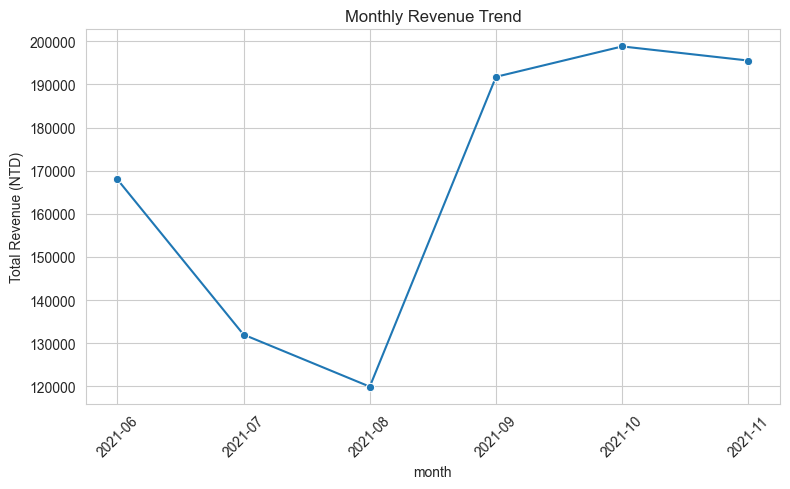

In [3]:
monthly_revenue = df.groupby("month")["total_amount"].sum().reset_index()
plt.figure(figsize=(8, 5))
sns.lineplot(data=monthly_revenue, x="month", y="total_amount", marker="o")
plt.title("Monthly Revenue Trend")
plt.ylabel("Total Revenue (NTD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Trend 2: Customer Type Distribution

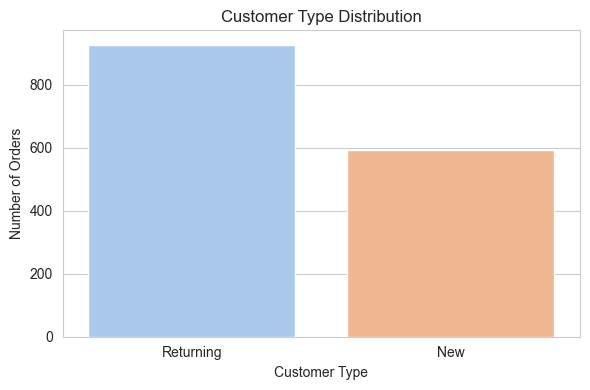

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="customer_type", hue="customer_type", palette="pastel", legend=False)
plt.title("Customer Type Distribution")
plt.ylabel("Number of Orders")
plt.xlabel("Customer Type")
plt.tight_layout()
plt.show()

## Trend 3: Guest Count vs Avg Spend

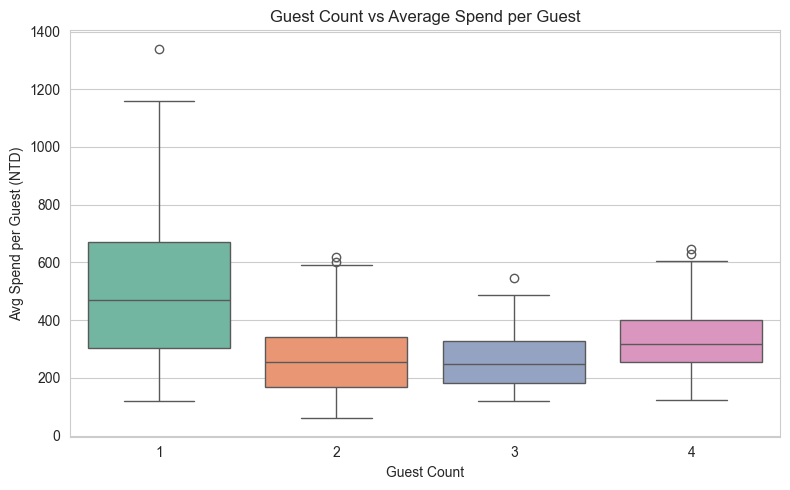

In [5]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="guest_count", y="avg_spend_per_guest", hue="guest_count", palette="Set2", legend=False)
plt.title("Guest Count vs Average Spend per Guest")
plt.xlabel("Guest Count")
plt.ylabel("Avg Spend per Guest (NTD)")
plt.tight_layout()
plt.show()

## Trend 4: Wait Time vs Total Amount

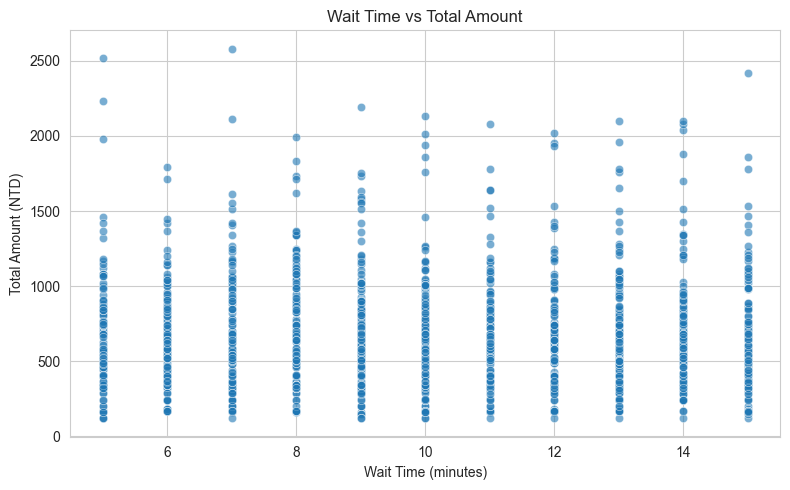

In [6]:
df["wait_time_min"] = (
    pd.to_datetime(df["serve_time"], format="%H:%M") -
    pd.to_datetime(df["order_time"], format="%H:%M")
).dt.total_seconds() / 60

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="wait_time_min", y="total_amount", alpha=0.6)
plt.title("Wait Time vs Total Amount")
plt.xlabel("Wait Time (minutes)")
plt.ylabel("Total Amount (NTD)")
plt.tight_layout()
plt.show()

## Trend 5: Order Heatmap by Hour and Weekday

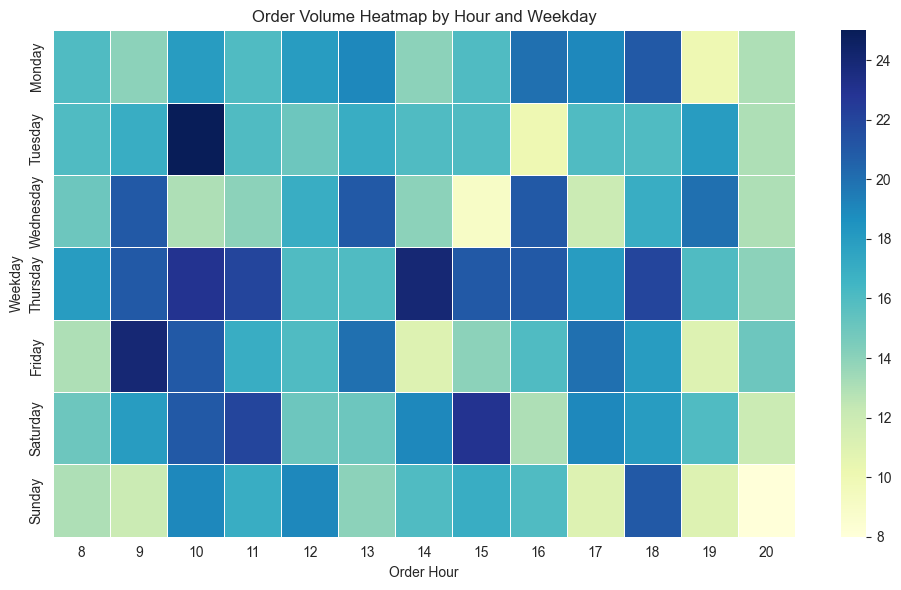

In [7]:
df["order_hour"] = pd.to_datetime(df["order_time"], format="%H:%M").dt.hour
df["weekday"] = pd.Categorical(df["weekday"], categories=[
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
], ordered=True)

heatmap_data = df.groupby(["weekday", "order_hour"], observed=False)["transaction_id"].count().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5)
plt.title("Order Volume Heatmap by Hour and Weekday")
plt.xlabel("Order Hour")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()

## Trend 6: Top 10 Best-Selling Products

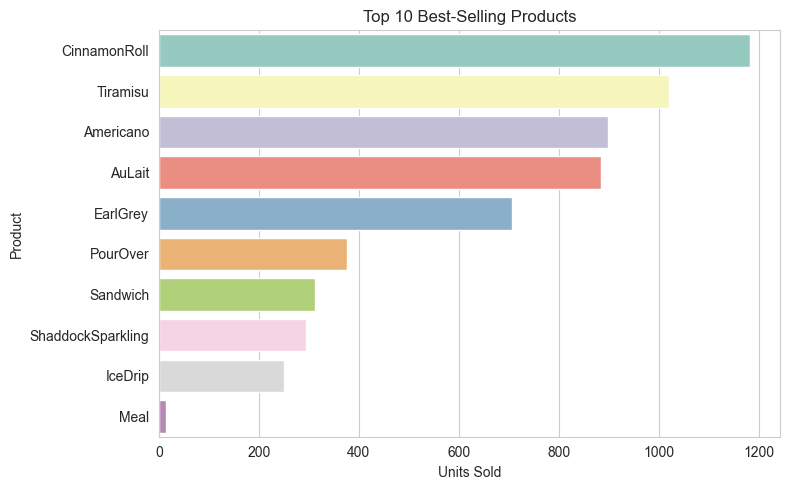

In [8]:
top_products = df_items.groupby("product")["qty"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 5))
sns.barplot(x=top_products.values, y=top_products.index, hue=top_products.index, palette="Set3", legend=False)
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Units Sold")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

## Trend 7: Product Price vs Quantity Sold

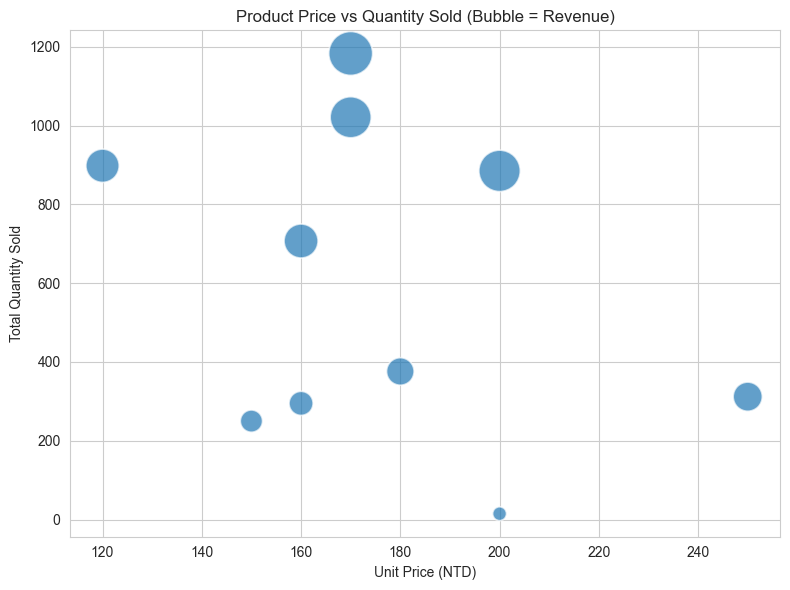

In [9]:
product_prices = {
    "EarlGrey": 160, "PourOver": 180, "AuLait": 200, "Sandwich": 250, "Meal": 200,
    "Tiramisu": 170, "CinnamonRoll": 170, "Americano": 120, "IceDrip": 150, "ShaddockSparkling": 160
}
product_summary = df_items.groupby("product")["qty"].sum().reset_index()
product_summary["price"] = product_summary["product"].map(product_prices)
product_summary["revenue"] = product_summary["qty"] * product_summary["price"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=product_summary, x="price", y="qty", size="revenue", legend=False, sizes=(100, 1000), alpha=0.7)
plt.title("Product Price vs Quantity Sold (Bubble = Revenue)")
plt.xlabel("Unit Price (NTD)")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()

## Trend 8: Product Preference by Customer Type

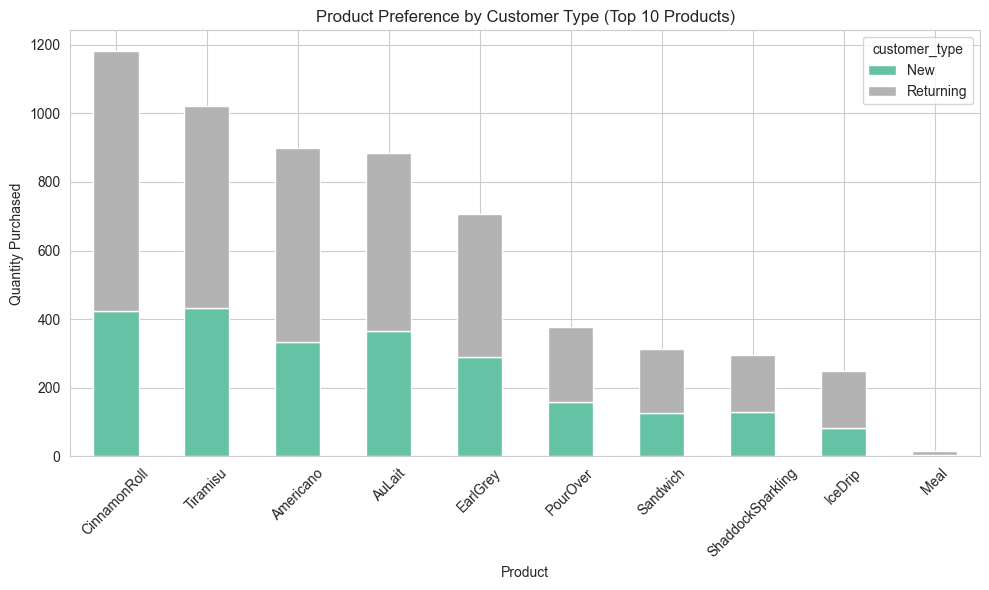

In [10]:
stacked_data = df_items.pivot_table(index="product", columns="customer_type", values="qty", aggfunc="sum").fillna(0)
stacked_data = stacked_data.loc[stacked_data.sum(axis=1).sort_values(ascending=False).index[:10]]

stacked_data.plot(kind="bar", stacked=True, colormap="Set2", figsize=(10, 6))
plt.title("Product Preference by Customer Type (Top 10 Products)")
plt.xlabel("Product")
plt.ylabel("Quantity Purchased")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Trend 9: Top 10 Association Rules by Lift

In [11]:
# 建立規則欄位
rules["rule"] = rules["antecedents"] + " → " + rules["consequents"]

# 取前 N 筆 lift 最高的規則
top_n = 10
rules_top = rules.sort_values(by="lift", ascending=False).head(top_n)

# 每條 bar 用不同顏色 → 將 rule 作為 color 分群欄位
fig = px.bar(
    rules_top,
    x="lift",
    y="rule",
    orientation="h",
    color="rule",  # 🎨 關鍵設定：依 rule 區分顏色
    hover_data={
        "support": ':.4f',
        "confidence": ':.4f',
        "lift": ':.2f',
        "rule": True
    },
    title=f"Top {top_n} Association Rules by Lift",
    labels={"lift": "Lift", "rule": "Rule"}
)

fig.update_layout(
    height=500,
    yaxis={'categoryorder': 'total ascending'},
    showlegend=False  # 不顯示圖例，避免顏色重複列出
)

fig.show()

## Trend 10: Support vs Confidence (Bubble Size = Lift)

In [12]:
# 建立規則欄位
rules["rule"] = rules["antecedents"] + " → " + rules["consequents"]

# 建立 Plotly 氣泡圖
fig = px.scatter(
    rules,
    x="support",
    y="confidence",
    size="lift",
    color="rule",  # 可省略此行，保留會使每個氣泡色彩不同
    hover_name="rule",
    hover_data={
        "support": ':.4f',
        "confidence": ':.4f',
        "lift": ':.2f',
    },
    title="Support vs Confidence (Bubble Size = Lift)",
    labels={
        "support": "Support",
        "confidence": "Confidence",
        "lift": "Lift",
        "rule": "Rule"
    },
    size_max=40  # 控制氣泡最大尺寸
)

fig.update_layout(height=600)
fig.show()
